In [ ]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
from sklearn import preprocessing
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from tensorflow.keras.optimizers import RMSprop
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### word2vec

In [ ]:
from __future__ import print_function
from collections import OrderedDict

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt

import os
import sys
import codecs
import re
import numpy as np

parameters = OrderedDict()
parameters['word_dim'] = 300

In [ ]:
datanew = pd.read_csv('/content/drive/MyDrive/archive/train.txt', sep=';', engine='python', names=['col', 'senti'])
datanew.head()

,col,senti
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
## encode sentiment column to onehot
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(datanew['senti'].to_numpy().reshape(-1, 1))
onehot_sentiment = enc.transform(datanew['senti'].to_numpy().reshape(-1, 1)).toarray()
# onehot_sentiment = onehot_sentiment.reshape((40000, 1, 13))
datanew.insert(1, "onehot_sentiment", list(onehot_sentiment))
datanew

,col,onehot_sentiment,senti
0,i didnt feel humiliated,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
1,i can go from feeling so hopeless to so damned...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
2,im grabbing a minute to post i feel greedy wrong,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
3,i am ever feeling nostalgic about the fireplac...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",love
4,i am feeling grouchy,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
15996,i am now turning and i feel pathetic that i am...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
15997,i feel strong and good overall,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",joy
15998,i feel like this was such a rude comment and i...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger


### encode word

In [ ]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    (item:count) pairs
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    
    return:
    dico: dictionary of (word:frequency) pairs
    word_to_id: dictionary of (word, id)
    id_to_word: dictionary of (id, word)
    """
    words = [[x.lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
## tokenising sentences
raw_content = datanew['col'].to_numpy()

processed_docs = []
for doc in raw_content:
    tokens = word_tokenize(doc)
#        filtered = [word for word in tokens if word not in stop_words]
#        stemmed = [stemmer.stem(word) for word in filtered]
    processed_docs.append(tokens)

In [ ]:
dico_words,word_to_id,id_to_word = word_mapping(processed_docs, True)

Found 15211 unique words (306805 in total)


In [ ]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [ ]:
def prepare_dataset(sentences, word_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        data.append({
            'str_words': str_words, #list of all words in the sentence
            'words': words, #list of word index for all words in the sentence
        })
    return data

data = prepare_dataset(
    processed_docs, word_to_id, True
)

print("{} sentences".format(len(data)))

16000 sentences


In [ ]:
all_word_embeds = {}
for i, line in enumerate(codecs.open('/content/drive/MyDrive/data/glove.6B.300d.txt', 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [ ]:
len(all_word_embeds)

400000

In [ ]:
len(word_embeds)

15211

In [ ]:
word_embeds

array([[ 0.02391364,  0.10542083,  0.05034357, ...,  0.17743688,
         0.23168229,  0.22576195],
       [-0.13292   ,  0.16985   , -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62902   ],
       [ 0.19787   ,  0.102     ,  0.037849  , ...,  0.21781   ,
        -0.080212  ,  0.10157   ],
       ...,
       [-0.037667  , -0.37043   ,  0.60163   , ...,  0.24776   ,
         0.75869   , -0.057032  ],
       [ 0.34759   ,  0.33437   , -0.26603   , ...,  0.94051   ,
         0.30409   ,  0.32668   ],
       [-0.33141   , -0.19132   , -0.037934  , ...,  0.28595   ,
         0.14024   , -0.29579   ]])

In [ ]:
from scipy import spatial

dataSetI = all_word_embeds['dog'].tolist()
dataSetII = all_word_embeds['cat'].tolist()
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
result

0.6816746611786186

In [ ]:
pd.DataFrame(data)["words"].apply(lambda x: len(x)).max()

66

In [ ]:
word_indices = [i['words'] for i in data]
padded_indices = []
for sent in word_indices:
    padding_size = 110 - len(sent)
    padded = sent + [0 for i in range(padding_size)]
    padded_indices.append(padded)

In [ ]:
datanew.insert(1, "padded_indices", list(padded_indices))
datanew

,col,padded_indices,onehot_sentiment,senti
0,i didnt feel humiliated,"[1, 139, 2, 685, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
1,i can go from feeling so hopeless to so damned...,"[1, 39, 100, 59, 7, 14, 495, 4, 14, 3641, 555,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
2,im grabbing a minute to post i feel greedy wrong,"[16, 3238, 6, 1164, 4, 287, 1, 2, 494, 446, 0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
3,i am ever feeling nostalgic about the fireplac...,"[1, 23, 164, 7, 670, 26, 5, 4516, 1, 58, 47, 8...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",love
4,i am feeling grouchy,"[1, 23, 7, 1074, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,"[1, 31, 56, 6, 45, 4267, 51, 11, 5, 7974, 3, 1...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
15996,i am now turning and i feel pathetic that i am...,"[1, 23, 57, 1248, 3, 1, 2, 624, 8, 1, 23, 71, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",sadness
15997,i feel strong and good overall,"[1, 2, 325, 3, 101, 1320, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",joy
15998,i feel like this was such a rude comment and i...,"[1, 2, 13, 22, 19, 181, 6, 575, 1221, 3, 16, 3...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",anger


In [ ]:
set(datanew["senti"])

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [ ]:
from sklearn.model_selection import train_test_split
X = datanew['padded_indices'].to_numpy()
y = datanew['onehot_sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X train: ", len(X_train), X_train.shape)
print("y train: ", len(y_train), y_train.shape)
print("y test: ", len(y_test), y_test.shape)

X train:  11200 (11200,)
y train:  11200 (11200,)
y test:  4800 (4800,)


In [ ]:
X_train = np.array([np.array(x) for x in X_train])
y_train = np.array([np.array(x) for x in y_train])
X_test = np.array([np.array(x) for x in X_test])
y_test = np.array([np.array(x) for x in y_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11200, 110)
(11200, 6)
(4800, 110)
(4800, 6)


### Zhou model

In [ ]:
import tensorflow as tf
# so that dont have to rerun
tf.compat.v1.reset_default_graph()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
# from keras_self_attention import SeqSelfAttention, SeqWeightedAttention


class ZhouBLSTMCNNModel:

    def __init__(self,
        embedding,
        em_drop_rate = 0.5,
        lstm_units   = 300,
        lstm_drop_rate = 0.5,
        conv_size    = (3, 3),
        conv_filters = 100,
        pool_size    = (2, 2),
        pool_drop_rate = 0.5):
        '''Constructor.
        # Parameters:
        embedding: Numpy array representing the embedding.
        em_drop_rate: Drop rate after the embedding layer.
        lstm_units: Size of the internal states of the LSTM cells.
        lstm_drop_rate: Drop rate after the lstm layer.
        conv_size: Size of the convolutions.
        conv_filters: Number of convolutions filters.
        pool_size: Size for the max pooling layer.
        pool_drop_rate: Drop rate of the max pooling layer.
        '''
        self._embedding      = embedding
        self._em_drop_rate   = em_drop_rate
        self._lstm_units     = lstm_units
        self._lstm_drop_rate = lstm_drop_rate
        self._conv_size      = conv_size
        self._conv_filters   = conv_filters
        self._pool_size      = pool_size
        self._pool_drop_rate = pool_drop_rate

    def __call__(self, input):
        self._embedding_tf = self._create_embedding_layer(
            self._em_drop_rate, self._embedding, input)

        self._sequences_tf = self._create_blstm_layer(
            self._lstm_units,
            self._lstm_drop_rate,
            self._embedding_tf)

        self._convolution_tf = self._create_convolutional_layer(
            self._conv_size,
            self._conv_filters,
            self._sequences_tf)
        
        self._pooling_tf = self._create_maxpooling_layer(
            self._pool_size,
            self._pool_drop_rate,
            self._convolution_tf)

        self._flatten_tf = self._create_flatten_layer(self._pooling_tf)

        return self._flatten_tf

    def summary(self):
        print("embedding: " + str(self._embedding_tf.shape))
        print("lstm: " + str(self._sequences_tf.shape))
        print("conv: " + str(self._convolution_tf.shape))
        print("pooling: " + str(self._pooling_tf.shape))
        print("flatten: " + str(self._flatten_tf.shape))

    # this function converts each word from input_x into dense vector of dimension 300 (dimension depending on word2vec)
    # embedding  = word_vector
    def _create_embedding_layer(self, em_drop_rate, embedding, input_x):
        embedding = tf.Variable(initial_value=embedding)

        embedded_chars = tf.nn.embedding_lookup(  # lookup word_vector(embedding) by index (input_x)
            embedding, tf.cast(input_x, 'int32'))

        return tf.nn.dropout(embedded_chars, rate=em_drop_rate)

    # bidirectional lstm layer
    # 
    def _create_blstm_layer(self, lstm_units, lstm_drop_rate, embedding):
        lstm_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(lstm_units)
        sequence = tf.unstack(embedding, axis=1) #embedded input words
        
        # hs, _, _ are outputs, output_state_fw, output_state_bw respectively
        hs, _, _ = tf.compat.v1.nn.static_bidirectional_rnn(lstm_cell, lstm_cell, #forward and backward direction
            sequence, #input
            dtype=tf.float32)
        
        hs = tf.stack(
            values=hs,
            axis=1)
        ss = tf.math.reduce_sum(
            tf.reshape(hs, shape=[-1, hs.shape[1], 2, lstm_units]),
            axis=2
        )
        
        # attn = SeqSelfAttention(attention_activation='sigmoid')(ss)

        return tf.nn.dropout(ss, rate=lstm_drop_rate)

    def _create_convolutional_layer(self,
        conv_size, num_filters, tensor):
        
        print(str(tensor.shape))

        filter_heigth = conv_size[0]
        filter_width  = conv_size[1]

        filter_shape = [filter_heigth, filter_width,
            1, num_filters]

        W = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=filter_shape,
                stddev=0.1))
        b = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=[num_filters]))

        tensor_expanded = tf.expand_dims(tensor, -1)
        conv = tf.nn.conv2d(
            input=tensor_expanded,
            filters=W, #####filter to filters, idk if it changed stuff
            strides=[1,1,1,1],
            padding='VALID')

        bias = tf.nn.bias_add(conv, b)
        c = tf.nn.relu(bias)

        return c

    def _create_maxpooling_layer(self, size, pool_drop_rate, conv):
        pooled = tf.nn.max_pool3d(
            input=tf.expand_dims(conv, -1),
            ksize=[1, size[0], size[1], conv.shape[3], 1],
            strides=[1, size[0], size[1], conv.shape[3], 1],
            padding='VALID')
        
        return tf.nn.dropout(pooled, rate=pool_drop_rate)

    def _create_flatten_layer(self, tensor):
        return tf.reshape(tensor, [-1, tensor.shape[1] * tensor.shape[2]])


if __name__ == '__main__':
    embedding_size  = 300
    num_words       = 1000
    sentence_length = 10

    embedding = [
        [float(i) for i in range(embedding_size)] for _ in range(num_words)
    ]
    data = [
        [i     for i in range(sentence_length)],
        [i + 1 for i in range(sentence_length)]
    ]

    model = ZhouBLSTMCNNModel(embedding)
    model(data)
    model.summary()

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


(2, 10, 300)
embedding: (2, 10, 300)
lstm: (2, 10, 300)
conv: (2, 8, 298, 100)
pooling: (2, 4, 149, 1, 1)
flatten: (2, 596)


In [ ]:
import tensorflow as tf
from numba import jit, cuda

class Classifier:

    def __init__(self, model, input_length, output_length):
        '''Constructor.
        # Parameters:
        input_length: sentence length (max number of words in sentence)
        output_length: number of classes of sentiment
        '''
        self.model = model
        self.input_length = input_length
        self.output_length = output_length

    def compile(self, batch_size=32):
        tf.compat.v1.disable_eager_execution()
        self._ds_x = tf.compat.v1.placeholder(tf.float32, [None, self.input_length])
        self._ds_y = tf.compat.v1.placeholder(tf.float32, [None, self.output_length])

        ds = tf.compat.v1.data.Dataset.from_tensor_slices((self._ds_x, self._ds_y))
        ds = ds.batch(batch_size)

        self._ds_it = ds.make_initializable_iterator()
        self._input, self._labels = self._ds_it.get_next()

        self._features = self.model(self._input)
        self._output = _create_dense_layer(self._features, self.output_length)

        self._create_acc_computations()
        self._create_backpropagation()

        self._session = tf.compat.v1.Session()
        self._session.run(tf.compat.v1.global_variables_initializer())
        self._session.run(tf.compat.v1.local_variables_initializer())

    def _create_acc_computations(self):
        self._predictions = tf.argmax(self._output, 1)
        labels = tf.argmax(self._labels, 1)
        self._accuracy = tf.reduce_mean(
            tf.cast(tf.equal(self._predictions, labels), 'float32'))

    def _create_backpropagation(self):
        losses = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(
            logits=self._output,
            labels=self._labels)
        self._loss = tf.reduce_mean(losses)

        optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = optimizer.compute_gradients(self._loss)

        self._train_op = optimizer.apply_gradients(
            grads_and_vars, global_step=global_step)

    def summary(self):
        print('input:', self._input.shape)
        self.model.summary()
        print('output:', self._output.shape)

#     @jit(target ="cuda")  
    def train(self, X_train, y_train, X_eval, y_eval, epochs=10):
        import time
        loss_ls, acc_ls, val_loss_ls, val_acc_ls = [],[],[],[]
        start_start = time.time()
        for e in range(epochs):
            start_time = time.time()
            loss, acc = self._train(X_train, y_train)
            loss_ls.append(loss)
            acc_ls.append(acc)
            duration = time.time() - start_time

            val_loss, val_acc = self._eval(X_eval, y_eval)
            val_loss_ls.append(val_loss)
            val_acc_ls.append(val_acc)

            output = 'Epoch: {}, loss = {:.4f}, acc = {:.4f}, val_loss = {:.4f}, val_acc = {:.4f}, Time = {:.2f}s'
            print(output.format(e + 1, loss, acc, val_loss, val_acc, duration))
        # endfor
        total_duration = time.time() - start_start
        return loss_ls, acc_ls, val_loss_ls, val_acc_ls, total_duration

#     @jit(target ="cuda")  
    def _train(self, X_train, y_train):
        import numpy as np

        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_train,
                self._ds_y: y_train
            })
        loss, acc, = [], []
        while True:
            try:
                _, vloss, vacc = self._session.run(
                    fetches=[self._train_op, self._loss, self._accuracy])

                loss.append(vloss)
                acc.append(vacc)
            except tf.errors.OutOfRangeError:
                break
        # endwhile

        loss, acc = np.mean(loss), np.mean(acc)
        return loss, acc

    def _eval(self, X_val, y_val):
        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_val,
                self._ds_y: y_val
            })

        loss, acc, = 0, 0
        while True:
            try:
                l, vloss, vacc = self._session.run(
                    fetches=[self._labels, self._loss, self._accuracy])

                loss += vloss * len(l)
                acc += vacc * len(l)
            except tf.errors.OutOfRangeError:
                break

        return loss / len(X_val), acc / len(X_val)

    def predict(self, X):
        import numpy as np

        self._session.run(self._ds_it.initializer,
                         feed_dict={
                             self._ds_x: X,
                             self._ds_y: np.empty((len(X), self.output_length))
                         }
                         )

        pred = list()
        while True:
            try:
                ppred = self._session.run(tf.nn.softmax(self._output))

                pred.extend(map(lambda l: l.tolist(), ppred))
            except tf.errors.OutOfRangeError:
                break

        return pred

def _create_dense_layer(x, output_length):
    '''Creates a dense layer
    '''
    input_size = x.shape[1] #.value
    W = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[input_size, output_length],
            stddev=0.1))
    b = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[output_length]))

    dense = tf.compat.v1.nn.xw_plus_b(x, W, b)

    return dense


if __name__ == '__main__':
    pass

In [ ]:
import pickle
import numpy as np
import sys
# from fen.classifier import Classifier
# from fen.pzhou_tf import ZhouBLSTMCNNModel

if __name__ == '__main__':

#     (X_train, y_train), (X_eval, y_eval) = (X_train, y_train), (X_test, y_test)

    word_vector = word_embeds
    word_vector = word_vector.astype('float32')
    
    sentence_length = X_train[0].shape[0] # sentence length = 37 -- if less than 37, remaining is 0
    num_classes = y_train[0].shape[0] # 6 sentiment classes

#     with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=True):
    model = ZhouBLSTMCNNModel(embedding=word_vector) #pass in word_vector as lookup table

    classifier = Classifier(
        model=model,
        input_length=sentence_length,
        output_length=num_classes)

    classifier.compile(batch_size=10)
    classifier.summary()
    loss_ls, acc_ls, val_loss_ls, val_acc_ls, total_duration = classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_eval=X_test,
        y_eval=y_test,
        epochs=20
    )

    print("total duration: ", total_duration)
    print("Predictions:", classifier.predict(X_train[0:2]))
    print("Real:", y_train[0:2])

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


(None, 110, 300)
input: (None, 110)
embedding: (None, 110, 300)
lstm: (None, 110, 300)
conv: (None, 108, 298, 100)
pooling: (None, 54, 149, 1, 1)
flatten: (None, 8046)
output: (None, 6)
Epoch: 1, loss = 7.6261, acc = 0.2487, val_loss = 2.3275, val_acc = 0.2644, Time = 121.05s
Epoch: 2, loss = 2.0220, acc = 0.2808, val_loss = 1.8780, val_acc = 0.2865, Time = 137.04s
Epoch: 3, loss = 1.8059, acc = 0.2917, val_loss = 1.7547, val_acc = 0.2994, Time = 137.82s
Epoch: 4, loss = 1.7063, acc = 0.3057, val_loss = 1.6803, val_acc = 0.3060, Time = 118.18s
Epoch: 5, loss = 1.6507, acc = 0.3144, val_loss = 1.6409, val_acc = 0.3163, Time = 137.33s
Epoch: 6, loss = 1.6311, acc = 0.3202, val_loss = 1.6293, val_acc = 0.3094, Time = 117.95s
Epoch: 7, loss = 1.6277, acc = 0.3217, val_loss = 1.6129, val_acc = 0.3223, Time = 137.46s
Epoch: 8, loss = 1.6556, acc = 0.3113, val_loss = 1.6649, val_acc = 0.3125, Time = 137.61s
Epoch: 9, loss = 1.6452, acc = 0.3207, val_loss = 1.7472, val_acc = 0.2844, Time = 137

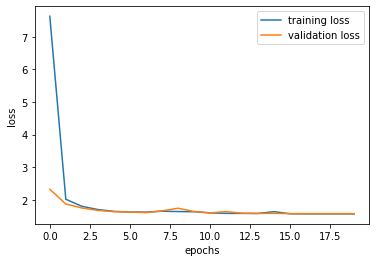

In [ ]:
epochslist = [i for i in range(0,20)]
plt.plot(epochslist, loss_ls, label='training loss')
plt.plot(epochslist, val_loss_ls, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

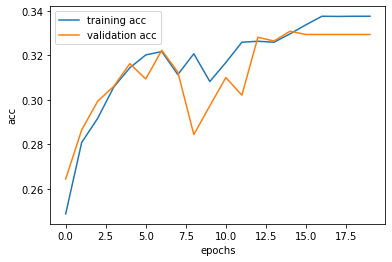

In [ ]:
plt.plot(epochslist, acc_ls, label = "training acc")
plt.plot(epochslist, val_acc_ls, label="validation acc")
# plt.title('training acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()